In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### **Read the raw data**

In [2]:
df = pd.read_csv("/kaggle/input/uber-uncleaned-dataset/Uber and Lyft Dataset Boston.csv")
df.head(7)

,id,timestamp,timezone,source,destination,cab_type,product_id,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800
5,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,1.545071e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_lux,Lux Black,16.5,0.44,...,0.0221,1545066000,34.19,1545048000,40.66,1545022800,27.39,1545044400,34.97,1545080400
6,462816a3-820d-408b-8549-0b39e82f65ac,1.543209e+09,America/New_York,Back Bay,Northeastern University,Lyft,lyft_plus,Lyft XL,10.5,1.08,...,0.1245,1543251600,40.67,1543233600,46.46,1543255200,37.45,1543291200,43.81,1543251600


In [3]:
df["timezone"].unique()

array(['America/New_York'], dtype=object)

In [4]:
df.columns

Index(['id', 'timestamp', 'timezone', 'source', 'destination', 'cab_type',
       'product_id', 'name', 'price', 'distance', 'surge_multiplier',
       'latitude', 'longitude', 'temperature', 'apparentTemperature',
       'short_summary', 'long_summary', 'precipIntensity', 'precipProbability',
       'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'icon', 'dewPoint', 'pressure',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime

## 🎯 Feature Selection for Ride Fare Prediction

After exploring the dataset in above cells, we proceed to select relevant features for **predicting ride fare**.

Our feature selection strategy is based on:
- 🚖 Factors directly influencing price (e.g., distance, surge multiplier)
- 🧭 Categorical identifiers (e.g., cab type, ride type, source/destination)
- 🌦️ Environmental conditions (e.g., temperature, weather summaries)

---

### ✅ Selected Features

| Feature | Reason for Inclusion |
|--------|-----------------------|
| `source`, `destination` | Pickup and drop-off locations affect pricing zones and distance. |
| `cab_type`, `product_id`, `name` | Identify ride service and vehicle class (Uber, Lyft, Shared, etc.). |
| `distance`, `surge_multiplier` | Core pricing factors. |
| `price` | 🎯 Target variable to predict. |
| `apparentTemperature` | More realistic representation of how weather feels than raw temperature. |
| `humidity`, `windSpeed`, `visibility` | May affect ride demand, delays, or availability. |
| `short_summary`, `long_summary`, `icon` | Weather context, useful for exploratory data analysis. Text data. |
| `pressure`, `cloudCover`, `uvIndex` | Additional weather attributes that may impact rider behavior. |

We retain these weather columns for initial analysis and will evaluate their statistical impact during **EDA** and **feature correlation** analysis. We might drop more features during EDA.

---

### ❌ Dropped Features

| Feature | Reason for Removal |
|--------|--------------------|
| `dewPoint` | Overlaps with `humidity`; redundant. |
| `temperature`, `temperatureHigh`, `temperatureLow`, etc. | Covered better by `apparentTemperature`. |
| Time-related fields | Too granular or not directly useful for fare prediction. |

---

### 📌 Next Step

We now create a filtered dataset with only the selected features.


In [5]:
selected_columns = [
    "timestamp","source", "destination", "cab_type", "product_id", "name",
    "distance", "surge_multiplier", "apparentTemperature", "price",
    "humidity", "windSpeed", "visibility",
    "short_summary", "long_summary", "icon",
    "pressure", "cloudCover", "uvIndex"
]

df = df[selected_columns]
df.head()

,timestamp,source,destination,cab_type,product_id,name,distance,surge_multiplier,apparentTemperature,price,humidity,windSpeed,visibility,short_summary,long_summary,icon,pressure,cloudCover,uvIndex
0,1.544953e+09,Haymarket Square,North Station,Lyft,lyft_line,Shared,0.44,1.0,37.12,5.0,0.68,8.66,10.000,Mostly Cloudy,Rain throughout the day.,partly-cloudy-night,NaN,0.72,0
1,1.543284e+09,Haymarket Square,North Station,Lyft,lyft_premier,Lux,0.44,1.0,37.35,11.0,0.94,11.98,4.786,Rain,"Rain until morning, starting again in the eve...",rain,1003.97,1.00,0
2,1.543367e+09,Haymarket Square,North Station,Lyft,lyft,Lyft,0.44,1.0,32.93,7.0,0.75,7.33,10.000,Clear,Light rain in the morning.,clear-night,992.28,0.03,0
3,1.543554e+09,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,0.44,1.0,29.63,26.0,0.73,5.28,10.000,Clear,Partly cloudy throughout the day.,clear-night,1013.73,0.00,0
4,1.543463e+09,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,0.44,1.0,30.88,9.0,0.7,9.14,10.000,Partly Cloudy,Mostly cloudy throughout the day.,☁️rainn%%,998.36,0.44,0


### **Dropping Duplicates**

In [6]:
df.duplicated().sum()

1250

In [7]:
df = df[~df.duplicated()]

### **Renaming Columns**

In [8]:
# Renaming multiple columns for better clarity and consistency
df.rename(columns={
    "price": "fare",
    "cab_type": "ride_company",
    "product_id": "vehicle_id",
    "name": "vehicle",
    "apparentTemperature": "temperature_F",
    "short_summary": "weather_desc_short",
    "long_summary": "weather_desc_long",
    "windSpeed": "wind_speed",
    "windGust": "wind_gust",
    "icon": "weather_status",
    "cloudCover": "cloud_cover",
    "uvIndex": "uv_index"
}, inplace=True)


### **Extract date, hour, day of the week, and month from the timestamp column.**

In [9]:
# Convert UNIX timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').dt.floor("S")

# Extract datetime features
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()
df["month"] = df["timestamp"].dt.month

/tmp/ipykernel_13/150795981.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').dt.floor("S")


### **Column reordering and Row Sorting**

In [10]:
cols = ['timestamp', 'date', 'hour', 'day_of_week', 'month', 'source', 'destination', 'ride_company', 'vehicle_id', 'vehicle', 'visibility', 'cloud_cover', 
        'uv_index', 'distance', 'surge_multiplier', 'fare', 'temperature_F', 'humidity', 'wind_speed', 'weather_desc_short', 'weather_desc_long', 'weather_status', 'pressure']
df = df[cols]
# Sort the DataFrame by timestamp in ascending order
df = df.sort_values(by="timestamp").reset_index(drop=True)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle_id,vehicle,...,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Haymarket Square,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.16,1.00,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.57,1.00,NaN,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
2,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_lux,Lux Black,...,4.46,1.75,62.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
3,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_premier,Lux,...,4.46,1.75,47.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
4,2018-11-26 03:40:46,2018-11-26,3,Monday,11,North Station,Fenway,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,3.05,1.00,10.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691821 entries, 0 to 691820
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           691821 non-null  datetime64[ns]
 1   date                691821 non-null  object        
 2   hour                691821 non-null  int32         
 3   day_of_week         691821 non-null  object        
 4   month               691821 non-null  int32         
 5   source              691821 non-null  object        
 6   destination         691821 non-null  object        
 7   ride_company        691821 non-null  object        
 8   vehicle_id          691821 non-null  object        
 9   vehicle             691821 non-null  object        
 10  visibility          691821 non-null  float64       
 11  cloud_cover         691821 non-null  float64       
 12  uv_index            691821 non-null  int64         
 13  distance            684890 no

### **Change Data type**
humidity, pressure, surge_multiplier are numerical columns but has object data type. pd.to_numeric will convert Non-numeric strings to NaN. 

In [12]:
df["humidity"] = pd.to_numeric(df["humidity"], errors="coerce")
df["pressure"] = pd.to_numeric(df["pressure"], errors="coerce")
df["surge_multiplier"] = pd.to_numeric(df["surge_multiplier"], errors="coerce")

In [13]:
df.describe()

,timestamp,hour,month,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,pressure
count,691821,691821.000000,691821.000000,691821.000000,691821.000000,691821.000000,684890.000000,691821.000000,637194.000000,683782.000000,682465.000000,691821.000000,667079.000000
mean,2018-12-05 21:42:19.921011456,11.618518,11.587052,8.468426,0.686394,0.248991,2.399801,1.013895,18.136820,36.091633,0.741067,6.235108,1010.107340
min,2018-11-26 03:40:46,0.000000,11.000000,0.717000,0.000000,0.000000,0.020000,1.000000,2.500000,12.130000,0.380000,0.450000,988.090000
25%,2018-11-28 22:29:09,6.000000,11.000000,8.432000,0.370000,0.000000,1.280000,1.000000,9.000000,31.910000,0.640000,3.410000,999.840000
50%,2018-12-02 08:03:00,12.000000,12.000000,9.880000,0.820000,0.000000,2.170000,1.000000,13.500000,35.970000,0.710000,5.920000,1009.250000
75%,2018-12-14 22:45:13,18.000000,12.000000,9.996000,1.000000,0.000000,2.940000,1.000000,22.500000,40.720000,0.880000,8.410000,1021.860000
max,2018-12-18 19:15:11,23.000000,12.000000,10.000000,1.000000,2.000000,149.200000,3.000000,1300.000000,85.830000,0.960000,37.500000,1035.550000
std,NaN,6.947689,0.492364,2.602581,0.358578,0.474179,3.572232,0.091722,27.480774,8.209859,0.138601,3.265309,13.471712


#### price, distance, temperature, windSpeed has some outliers as their max is significantly larger than 75th percentile value. These needs to be removed or replaced with some realistic values. Let's take each feature and work on its outlier and missing values.

In [14]:
df.isnull().sum()

timestamp                 0
date                      0
hour                      0
day_of_week               0
month                     0
source                    0
destination               0
ride_company              0
vehicle_id                0
vehicle                   0
visibility                0
cloud_cover               0
uv_index                  0
distance               6931
surge_multiplier          0
fare                  54627
temperature_F          8039
humidity               9356
wind_speed                0
weather_desc_short        0
weather_desc_long         0
weather_status            0
pressure              24742
dtype: int64

### **Handling missing fare values.**
#### The price column has the highest number of missing values, approximately 8% of the dataset. Since this is our target variable, it's crucial to investigate the nature of these missing entries before deciding how to handle them.
#### Let’s display only the rows where the price is missing to better understand any patterns or correlations in the missing data.

In [15]:
df[df['fare'].isna()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle_id,vehicle,...,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Haymarket Square,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.16,1.0,NaN,41.83,0.92,0.510,Foggy,Rain in the morning and afternoon.,fog,1014.10
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.57,1.0,NaN,41.83,0.92,0.510,Foggy,Rain in the morning and afternoon.,fog,1014.10
5,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.71,1.0,NaN,41.83,0.92,0.510,Foggy,Rain in the morning and afternoon.,fog,1014.10
14,2018-11-26 03:40:46,2018-11-26,3,Monday,11,South Station,Beacon Hill,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.50,1.0,NaN,41.83,0.92,0.510,Foggy,Rain in the morning and afternoon.,fog,1014.10
37,2018-11-26 03:40:47,2018-11-26,3,Monday,11,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,41.83,0.92,1.275,Foggy,Rain in the morning and afternoon.,fog,1014.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691737,2018-12-18 19:15:09,2018-12-18,19,Tuesday,12,Theatre District,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.57,1.0,NaN,22.99,0.38,12.520,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691793,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,22.99,0.38,12.520,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691800,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Fenway,Back Bay,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,1.50,1.0,NaN,22.99,0.38,12.520,Clear,Mostly cloudy throughout the day.,clear-day,1011.55
691805,2018-12-18 19:15:11,2018-12-18,19,Tuesday,12,Fenway,Theatre District,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,...,2.66,1.0,NaN,22.99,0.38,12.520,Clear,Mostly cloudy throughout the day.,clear-day,1011.55


In [16]:
df[df['fare'].isna()].describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,timestamp,hour,month,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,pressure
count,54627,54627.000000,54627.000000,54627.000000,54627.000000,54627.000000,54072.000000,54627.0,0.0,53994.000000,53921.000000,54627.000000,52634.000000
mean,2018-12-05 22:26:30.720138496,11.626741,11.590129,8.458097,0.688307,0.248009,2.385976,1.0,NaN,36.125145,0.741597,6.227607,1010.164338
min,2018-11-26 03:40:46,0.000000,11.000000,0.717000,0.000000,0.000000,0.020000,1.0,NaN,12.130000,0.380000,0.450000,988.090000
25%,2018-11-28 22:48:38.500000,6.000000,11.000000,8.432000,0.370000,0.000000,1.300000,1.0,NaN,31.920000,0.640000,3.410000,999.890000
50%,2018-12-02 09:07:56,12.000000,12.000000,9.876000,0.830000,0.000000,2.170000,1.0,NaN,35.980000,0.710000,5.920000,1009.430000
75%,2018-12-14 23:10:16,18.000000,12.000000,9.996000,1.000000,0.000000,2.860000,1.0,NaN,40.800000,0.880000,8.410000,1021.860000
max,2018-12-18 19:15:11,23.000000,12.000000,10.000000,1.000000,2.000000,139.400000,1.0,NaN,85.830000,0.960000,37.500000,1035.550000
std,NaN,6.936359,0.491814,2.612476,0.357983,0.472120,3.368683,0.0,NaN,8.225299,0.138821,3.272792,13.435681


### Now, we look at the rows where the price is present to contrast them with the missing-price entries.

In [17]:
df[~df["fare"].isna()].head()

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle_id,vehicle,...,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
2,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_lux,Lux Black,...,4.46,1.75,62.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
3,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_premier,Lux,...,4.46,1.75,47.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
4,2018-11-26 03:40:46,2018-11-26,3,Monday,11,North Station,Fenway,Uber,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,...,3.05,1.00,10.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
6,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Theatre District,Lyft,lyft_luxsuv,Lux Black XL,...,3.03,1.00,34.0,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1
7,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Northeastern University,Beacon Hill,Lyft,lyft,Lyft,...,2.43,1.00,10.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1


### Upon inspection, we observe that for all rows where the price is missing, the corresponding name column is always "Taxi". In contrast, rows with a recorded price include a variety of ride types.

In [18]:
df[df['fare'].isna()]["vehicle"].unique()

array(['Taxi'], dtype=object)

### We confirm that only "Taxi" appears in the name column when price is missing.

In [19]:
df[~df['fare'].isna()]["vehicle"].unique()

array(['Lux Black', 'Lux', 'WAV', 'Lux Black XL', 'Lyft', 'UberX',
       'Shared', 'UberXL', 'Black SUV', 'Black', 'Lyft XL', 'UberPool'],
      dtype=object)

### This shows the diversity of ride types when price is available — indicating that the missing data is specific to Taxi.
### The missing price values are not due to random data loss but are structurally missing only for Taxi rides. Since no pricing data is available for these rides, we can safely remove them from our modeling dataset.

In [20]:
df = df[~df["fare"].isna()].reset_index(drop=True)

### **Handling outliers in price column**
75th percentile value is 22.5 USD while max is 6500 USD. All the rides of these dataset were inside Boston city. So, such high price will deteriorate the model performance. 
Min price is 2.5. Which shows no outlier in the lower spectrum.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


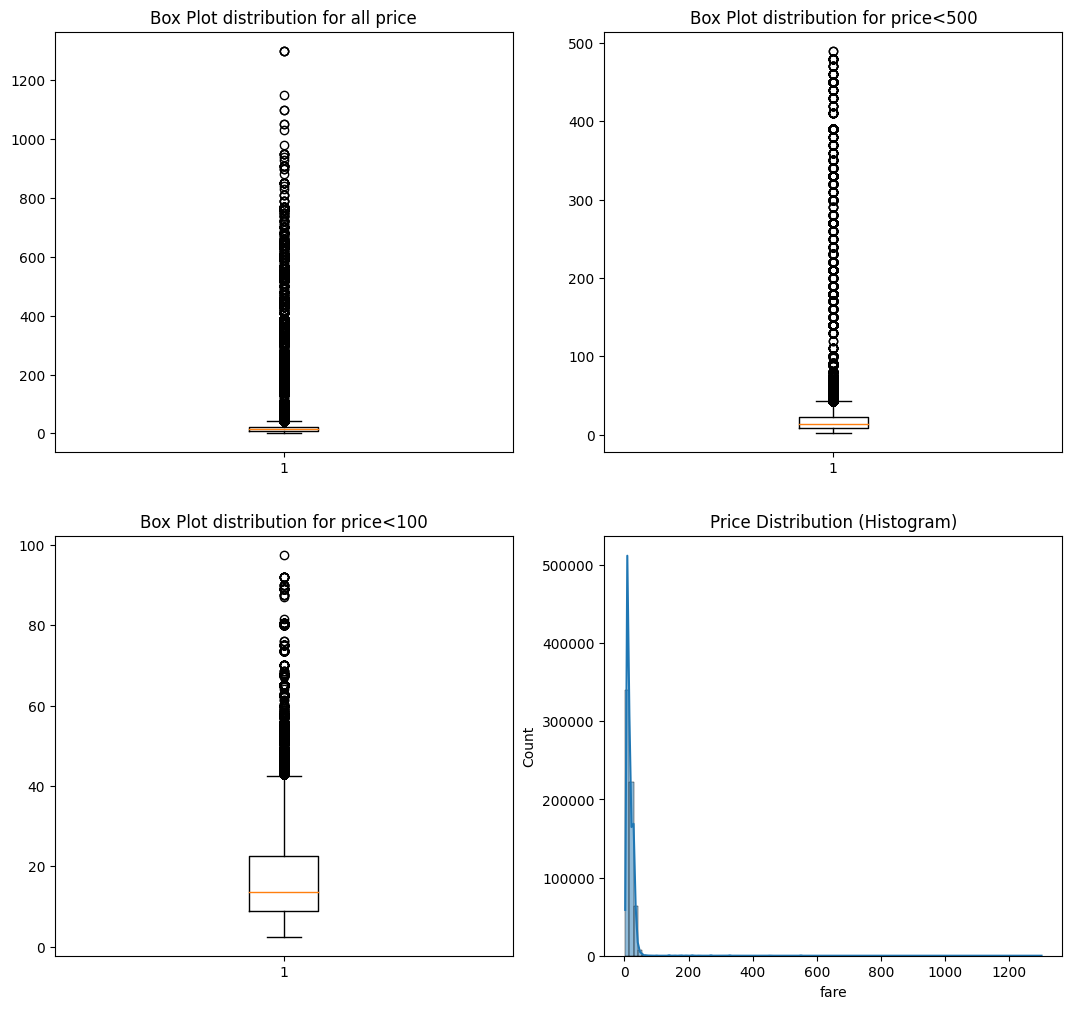

In [21]:
plt.figure(figsize=(13,12))
plt.subplot(2,2,1)
plt.boxplot(df["fare"])
plt.title("Box Plot distribution for all price")

plt.subplot(2,2,2)
plt.boxplot(df[df["fare"]<500]["fare"])
plt.title("Box Plot distribution for price<500")

plt.subplot(2,2,3)
plt.boxplot(df[df["fare"]<100]["fare"])
plt.title("Box Plot distribution for price<100")

plt.subplot(2,2,4)
sns.histplot(df["fare"], bins=100, kde=True)
plt.title("Price Distribution (Histogram)")
plt.show()

In [22]:
Q3 = df["fare"].quantile(0.75)
Q1 = df["fare"].quantile(0.25)

IQR = Q3-Q1
fare_thres_iqr = Q3 + 1.5 * IQR
fare_thres_vis = 80
print(fare_thres_iqr)

42.75


In [23]:
len(df[df["fare"]>80])/len(df["fare"])*100

0.5059683550064815

### Fare Distribution Analysis and Outlier Treatment

From the box plots and histogram of fare prices, we observe a right-skewed distribution, with the majority of fares concentrated below `$80`. The distribution becomes increasingly sparse above this range representing only 0.5% of the total data. Hence, we will treat them as outliers and impute them with better representatives.

Using the IQR method, we calculated the outlier threshold as `$42.75`

Although fares above `$42.75` are statistically considered outliers, those between `$42.75` and `$80` may be justified by high-end vehicle types. Therefore, we will further investigate this range to uncover underlying data patterns.


In [24]:
df[(df["fare"]>fare_thres_iqr) & (df["fare"]<fare_thres_vis)]["vehicle"].unique()

array(['Lux Black', 'Lux', 'Lux Black XL', 'Black SUV', 'Shared', 'Black',
       'UberXL', 'Lyft XL', 'UberX', 'WAV'], dtype=object)

In [25]:
df[(df["fare"]>fare_thres_iqr) & (df["fare"]<fare_thres_vis)].head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle_id,vehicle,...,distance,surge_multiplier,fare,temperature_F,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_lux,Lux Black,...,4.46,1.75,62.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,lyft_premier,Lux,...,4.46,1.75,47.5,41.83,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.10
247,2018-11-26 04:43:18,2018-11-26,4,Monday,11,Financial District,Fenway,Lyft,lyft_luxsuv,Lux Black XL,...,4.55,1.50,62.5,41.52,0.90,0.45,Overcast,Rain in the morning and afternoon.,cloudy,1014.06
288,2018-11-26 04:43:20,2018-11-26,4,Monday,11,Boston University,Financial District,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,4.72,1.00,43.5,41.52,0.90,0.45,Overcast !!,Rain in the morning and afternoon.,cloudy,1014.06
484,2018-11-26 05:03:01,2018-11-26,5,Monday,11,Fenway,Financial District,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,7.19,1.00,48.0,NaN,0.91,0.53,Overcast,"Rain until morning, starting again in the eve...",cloudy,1014.11


In [26]:
temp_df = df[((df["fare"]>fare_thres_iqr) & (df["fare"]<fare_thres_vis))]

# Print total number of high-fare rides and their average distance for each vehicle category
for vehicle in temp_df["vehicle"].unique():
    print(f"{vehicle}: {len( temp_df[temp_df['vehicle']==vehicle] )},    {temp_df[temp_df['vehicle']==vehicle] ['distance'].mean()}")

Lux Black: 562,    3.7037137681159424
Lux: 115,    4.157767857142857
Lux Black XL: 3263,    4.156019177234766
Black SUV: 1346,    6.286624251497006
Shared: 47,    1.9780851063829783
Black: 77,    7.721447368421055
UberXL: 60,    5.42135593220339
Lyft XL: 42,    5.860238095238095
UberX: 1,    4.41
WAV: 1,    4.41


#### We examined the number of rides and the average distance traveled for each vehicle type within a high-fare range (identified using both IQR and visualization thresholds). As expected, luxury vehicles such as Lux Black, Lux Black XL, Black SUV, and Black show a significant number of rides and higher average distances (ranging from ~3.7 to ~7.7 miles), which reasonably explains their higher fare values.

#### However, Shared rides deviate from this trend. Despite being designed as a low-cost, shared service, they appear in the high-fare range with an average distance of only ~2 miles. This contradicts the pricing model expected for shared rides and suggests that these are likely anomalies. Therefore, we will replace these entries with a better representative.

In [27]:
df["source"].unique()

array(['Boston University', 'North Station', 'Northeastern University',
       'Theatre District', 'Beacon Hill', 'South Station', 'North End',
       'Fenway', 'Back Bay', 'West End', 'Haymarket Square',
       'Financial District'], dtype=object)

In [28]:
df["destination"].unique()

array(['Financial District', 'Fenway', 'Theatre District', 'Beacon Hill',
       'Boston University', 'Northeastern University', 'North End',
       'Haymarket Square', 'West End', 'Back Bay', 'North Station',
       'South Station'], dtype=object)

In [29]:
df[["source","destination","vehicle"]].drop_duplicates()

,source,destination,vehicle
0,Boston University,Financial District,Lux Black
1,Boston University,Financial District,Lux
2,North Station,Fenway,WAV
3,Boston University,Theatre District,Lux Black XL
4,Northeastern University,Beacon Hill,Lyft
...,...,...,...
4386,Fenway,Theatre District,Lux Black
5320,Boston University,Theatre District,UberXL
5525,Beacon Hill,Northeastern University,Lux Black XL
5676,Beacon Hill,Northeastern University,Shared


#### Pickup and dropoff locations are all in Boston and they are just 12 unique location. And, ride type also influences the price. So, we took unique combinations of these 3 feature. We will calculate the avg fare of these unique combinations and impute that to the outliers. Also, the imputed fare will be rounded to multiple of 0.5 as the actual fare is multiple of 0.5.

In [30]:
# Define a function to round any value to the nearest 0.5
def round_to_nearest_half(x):
    return round(x * 2) / 2

# Calculate mean fare (<= threshold) for each (source, destination, vehicle) group
group_means = df[df["fare"] <= fare_thres_vis].groupby(
    ["source", "destination", "vehicle"]
)["fare"].mean()

# Replace outlier fares (> threshold) with the corresponding group mean (rounded to nearest 0.5)
df.loc[df["fare"] > fare_thres_vis, "fare"] = df[df["fare"] > fare_thres_vis].apply(
    lambda row: round_to_nearest_half(
        group_means.get(
            (row["source"], row["destination"], row["vehicle"]),
            df["fare"].mean()
        )
    ),
    axis=1
)

# Filter shared rides
shared_ride_df = df[df["vehicle"] == 'Shared']

# Calculate group-wise mean fare (excluding outliers) for shared rides
shared_ride_mean = shared_ride_df[shared_ride_df["fare"] < fare_thres_iqr].groupby(
    ["source", "destination"]
)["fare"].mean()

# Replace shared ride outlier fares with corresponding group mean (rounded)
shared_ride_df.loc[shared_ride_df["fare"] > fare_thres_iqr, "fare"] = shared_ride_df[shared_ride_df["fare"] > fare_thres_iqr].apply(
    lambda row: round_to_nearest_half(
        shared_ride_mean.get(
            (row["source"], row["destination"]),
            df["fare"].mean()
        )
    ),
    axis=1
)

# Update the original DataFrame with the cleaned shared ride fares
df.loc[df["vehicle"] == "Shared", "fare"] = shared_ride_df["fare"]


In [31]:
print("Null Values in fare column: ", df["fare"].isnull().sum())
df["fare"].describe()

Null Values in fare column:  0


count    637194.000000
mean         16.544011
std           9.306944
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          80.000000
Name: fare, dtype: float64

Max is 97.5. So, outliers removed.

### **Handling Outliers and Missing Values in Distance Column**

#### The distance column contains approximately 1% missing values. We will impute the missing values using geographical distance between pickup and drop-off locations based on the Haversine formula.



In [32]:
print("Null Values: ",df["distance"].isnull().sum())
df["distance"].describe()

Null Values:  6376


count    630818.000000
mean          2.400986
std           3.589143
min           0.020000
25%           1.280000
50%           2.170000
75%           2.950000
max         149.200000
Name: distance, dtype: float64

In [33]:
dist_threshold = df["distance"].quantile(0.99)
print(dist_threshold)
df[df["distance"]>dist_threshold][["fare","distance"]].head(7)

6.13


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,fare,distance
25,18.0,67.80
40,34.0,6.26
153,36.0,6.91
319,8.0,32.20
418,22.5,53.60
428,22.0,60.80
484,48.0,7.19


In [34]:
df[df["distance"]>dist_threshold]["fare"].sum() / df[df["distance"]>dist_threshold]["distance"].sum()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


0.8315844392421478

In [35]:
df[df["distance"]<dist_threshold]["fare"].sum() / df[df["distance"]<dist_threshold]["distance"].sum()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


7.6187959442892605

A temp_df is created to store non null value of distance and visualize the data distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


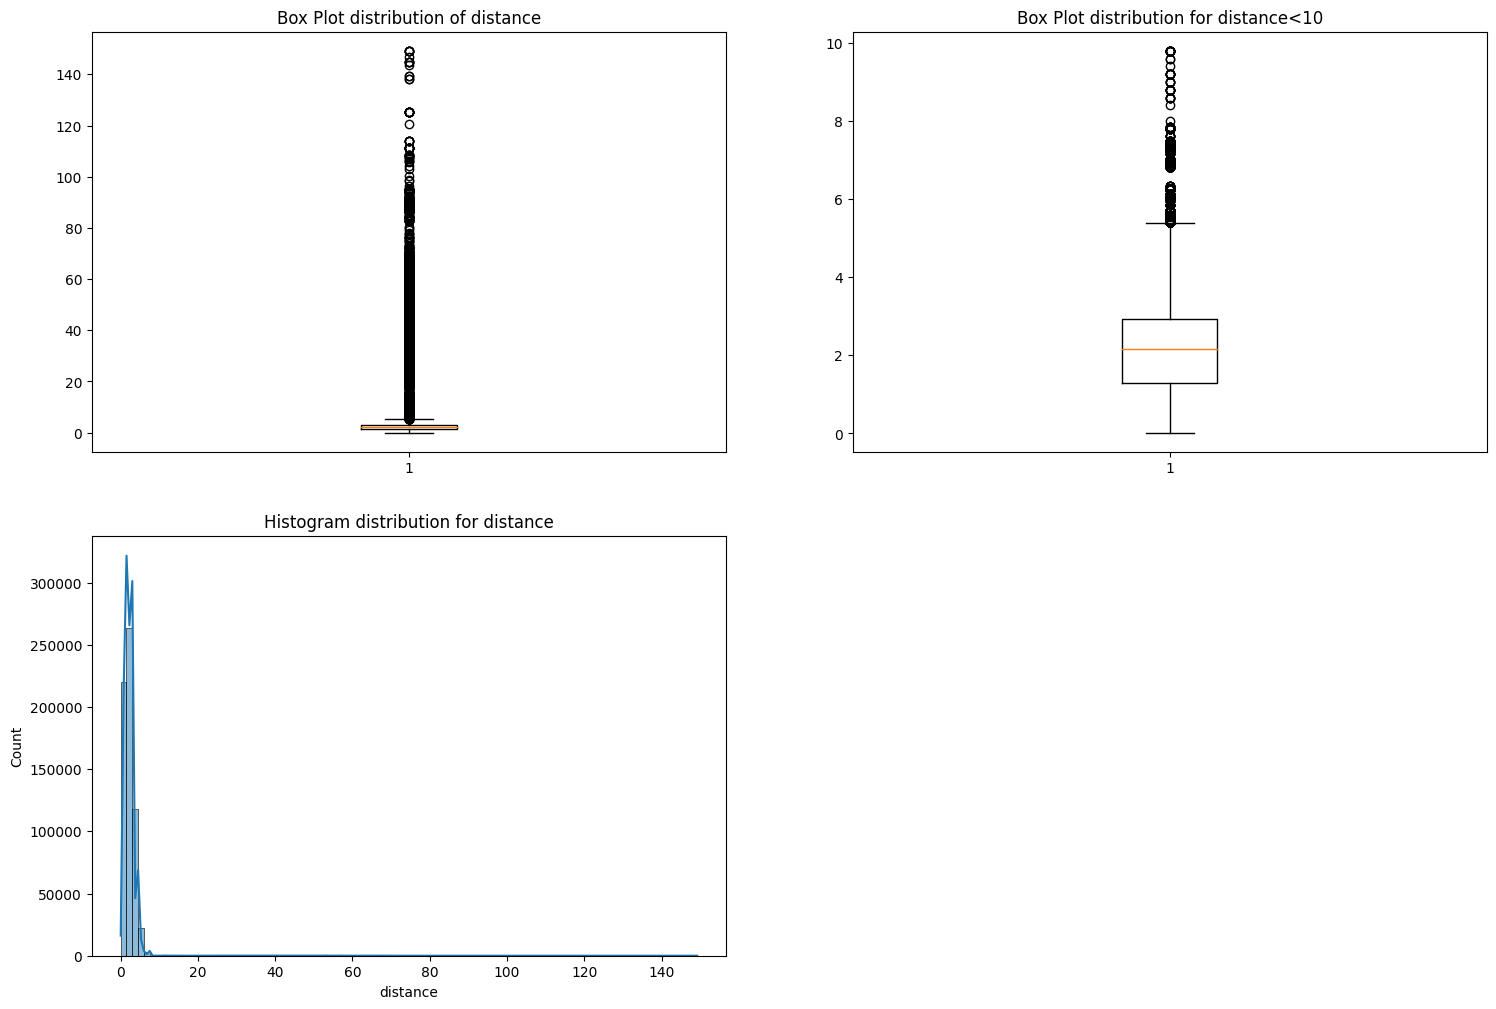

In [36]:
temp_df = df[~df["distance"].isna()]["distance"]

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.boxplot(temp_df)
plt.title("Box Plot distribution of distance")

plt.subplot(2,2,2)
plt.boxplot(temp_df[temp_df<10])
plt.title("Box Plot distribution for distance<10")

plt.subplot(2,2,3)
sns.histplot(temp_df, bins=100, kde=True)
plt.title("Histogram distribution for distance")
plt.show()

del temp_df

75th and 99th percentile data is 2.95 and 6.13 respectively. 149.2 being the max number clearly shows presence of outliers as all the rides was inside Boston city.
when distance is > 6.13(99th percentile value), price to distance ratio is 0.72, while ratio of 7.58 is seen in the opposite case. As, price didn't increase proportionally with distance, it tells us that those distances are outliers. And, the box plots also say the same.
We will replace both the outliers and missing value in same method. As, there are only 12 unique locations and 72 unique combinations of pickup location and dropoff location. We will calculate the avg distance of those unique combinations and impute the value to missing value and outliers.

In [37]:
df.loc[df["distance"]>dist_threshold, "distance"] = np.nan

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


We replaced the outliers with NaN and now all the missing values will be replaced by avg distance of the pickup and dropoff location.

In [38]:
# Group mean distances by source and destination
group_means = df.groupby(["source", "destination"])["distance"].mean()

# Replace NaN distances with the group mean or overall mean if group not found
df["distance"] = df.apply( lambda row: group_means.get((row["source"], row["distance"]), df['distance'].mean()) if pd.isna(row["distance"]) else row["distance"], axis=1)

df["distance"].isnull().sum()

0

In [39]:
print(df[["fare","distance"]].describe())
df[["fare","distance"]].isnull().sum()

                fare       distance
count  637194.000000  637194.000000
mean       16.544011       2.165190
std         9.306944       1.074128
min         2.500000       0.020000
25%         9.000000       1.300000
50%        13.500000       2.165190
75%        22.500000       2.880000
max        80.000000       6.130000


fare        0
distance    0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


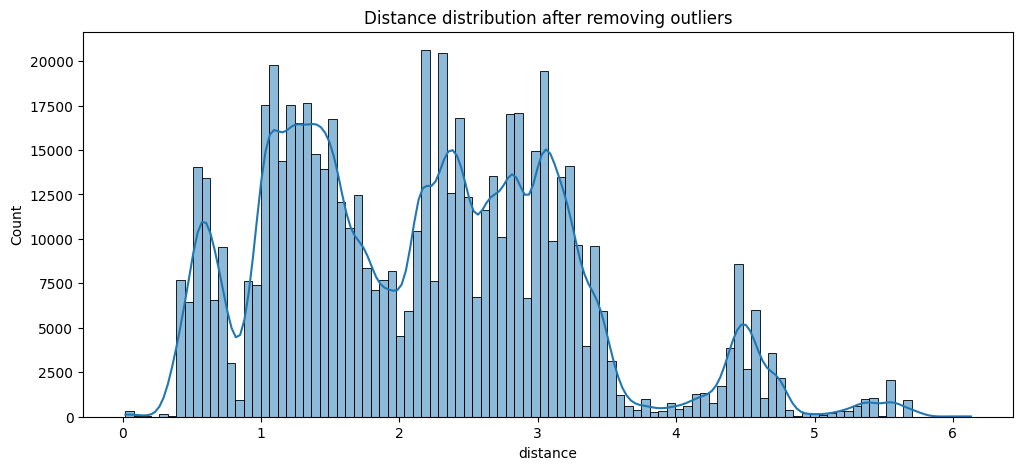

In [40]:
plt.figure(figsize=(12,5))
sns.histplot(df["distance"], bins=100, kde=True)
plt.title("Distance distribution after removing outliers")
plt.show()

Outliers and missing value for "price" and "distance" column has been handled.

## **Cleaning cab related data.**

In [41]:
print(df["ride_company"].unique())

['Lyft' 'Uber' 'Ubr' 'Liyft' 'lyft' 'uber' 'Ubre' 'Lyf' 'Ubee' 'Lft']


In [42]:
df.columns

Index(['timestamp', 'date', 'hour', 'day_of_week', 'month', 'source',
       'destination', 'ride_company', 'vehicle_id', 'vehicle', 'visibility',
       'cloud_cover', 'uv_index', 'distance', 'surge_multiplier', 'fare',
       'temperature_F', 'humidity', 'wind_speed', 'weather_desc_short',
       'weather_desc_long', 'weather_status', 'pressure'],
      dtype='object')

In [43]:
print(df["vehicle_id"].unique())

['lyft_lux' 'lyft_premier' '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 'lyft_luxsuv' 'lyft' '55c66225-fbe7-4fd5-9072-eab1ece5e23e' 'lyft_line'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '6c84fd89-3f11-4782-9b50-97c468b19529' 'lyft_plus'
 '997acbb5-e102-41e1-b155-9df7de0a73f2']


In [44]:
print(df["vehicle"].unique())

['Lux Black' 'Lux' 'WAV' 'Lux Black XL' 'Lyft' 'UberX' 'Shared' 'UberXL'
 'Black SUV' 'Black' 'Lyft XL' 'UberPool']


No column has missing values. ride_company has spelling mistakes. We will replace the value with "Lyft" if it starts with l/L and with "Uber" if it starts with u/U.

In [45]:
df["ride_company"] = df["ride_company"].apply(
    lambda x: "Lyft" if str(x).lower().startswith("l") else "Uber"
)

In [46]:
print(df["ride_company"].unique())

['Lyft' 'Uber']


In [47]:
df[df["ride_company"]=="Uber"]["vehicle"].unique()

array(['WAV', 'UberX', 'UberXL', 'Black SUV', 'Black', 'UberPool'],
      dtype=object)

In [48]:
df[df["ride_company"]=="Lyft"]["vehicle"].unique()

array(['Lux Black', 'Lux', 'Lux Black XL', 'Lyft', 'Shared', 'Lyft XL'],
      dtype=object)

In [49]:
df[df["ride_company"]=="Uber"]["vehicle_id"].unique()

array(['9a0e7b09-b92b-4c41-9779-2ad22b4d779d',
       '55c66225-fbe7-4fd5-9072-eab1ece5e23e',
       '6f72dfc5-27f1-42e8-84db-ccc7a75f6969',
       '6d318bcc-22a3-4af6-bddd-b409bfce1546',
       '6c84fd89-3f11-4782-9b50-97c468b19529',
       '997acbb5-e102-41e1-b155-9df7de0a73f2'], dtype=object)

In [50]:
df[df["ride_company"]=="Lyft"]["vehicle_id"].unique()

array(['lyft_lux', 'lyft_premier', 'lyft_luxsuv', 'lyft', 'lyft_line',
       'lyft_plus'], dtype=object)

In [51]:
df[df["ride_company"]=="Uber"][["vehicle","vehicle_id"]].drop_duplicates()

,vehicle,vehicle_id
2,WAV,9a0e7b09-b92b-4c41-9779-2ad22b4d779d
5,UberX,55c66225-fbe7-4fd5-9072-eab1ece5e23e
10,UberXL,6f72dfc5-27f1-42e8-84db-ccc7a75f6969
11,Black SUV,6d318bcc-22a3-4af6-bddd-b409bfce1546
13,Black,6c84fd89-3f11-4782-9b50-97c468b19529
26,UberPool,997acbb5-e102-41e1-b155-9df7de0a73f2


In [52]:
df[df["ride_company"]=="Lyft"][["vehicle","vehicle_id"]].drop_duplicates()

,vehicle,vehicle_id
0,Lux Black,lyft_lux
1,Lux,lyft_premier
3,Lux Black XL,lyft_luxsuv
4,Lyft,lyft
7,Shared,lyft_line
22,Lyft XL,lyft_plus


#### After inspecting the unique combinations of ride_type and vehicle_id, we found that each ride_type is always associated with a unique vehicle_id. This means the vehicle_id column does not provide any additional or distinct information beyond what is already captured by ride_type. Therefore, we drop the vehicle_id column as this is redundant.

In [53]:
df = df.drop("vehicle_id", axis=1)

## **Handling Outliers and Missing Values in Weather-Related Columns**

After cleaning and organizing the dataset, we now focus on key weather-related features: `temperature`, `humidity`, `wind_speed` and `pressure`. These features can contain outliers or missing values that may affect model performance. Besides, temperature is in fahrenheit. We need to convert that to degree celcius.

### **Strategy:**
1. **Detect and mark outliers** using the Interquartile Range (IQR) method.
2. **Replace outliers with `np.nan`** to treat them as missing data.
3. **Fill all missing values (including outliers) using forward and backward fill averaging**:
   - For each missing cell, take the average of the previous and next available values in the same column.


In [54]:
df["temperature_C"] = 5*(df["temperature_F"] - 32)/9 #Fahrenheit to Celcius
df.drop("temperature_F", axis=1, inplace=True)

In [55]:
df[["temperature_C","humidity","pressure","wind_speed"]].describe()

,temperature_C,humidity,pressure,wind_speed
count,629788.000000,628544.000000,614445.000000,637194.000000
mean,2.271533,0.741021,1010.102458,6.235751
std,4.560297,0.138582,13.474793,3.264668
min,-11.038889,0.380000,988.090000,0.450000
25%,-0.050000,0.640000,999.840000,3.410000
50%,2.205556,0.710000,1009.250000,5.920000
75%,4.844444,0.880000,1021.860000,8.410000
max,29.905556,0.960000,1035.550000,37.500000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

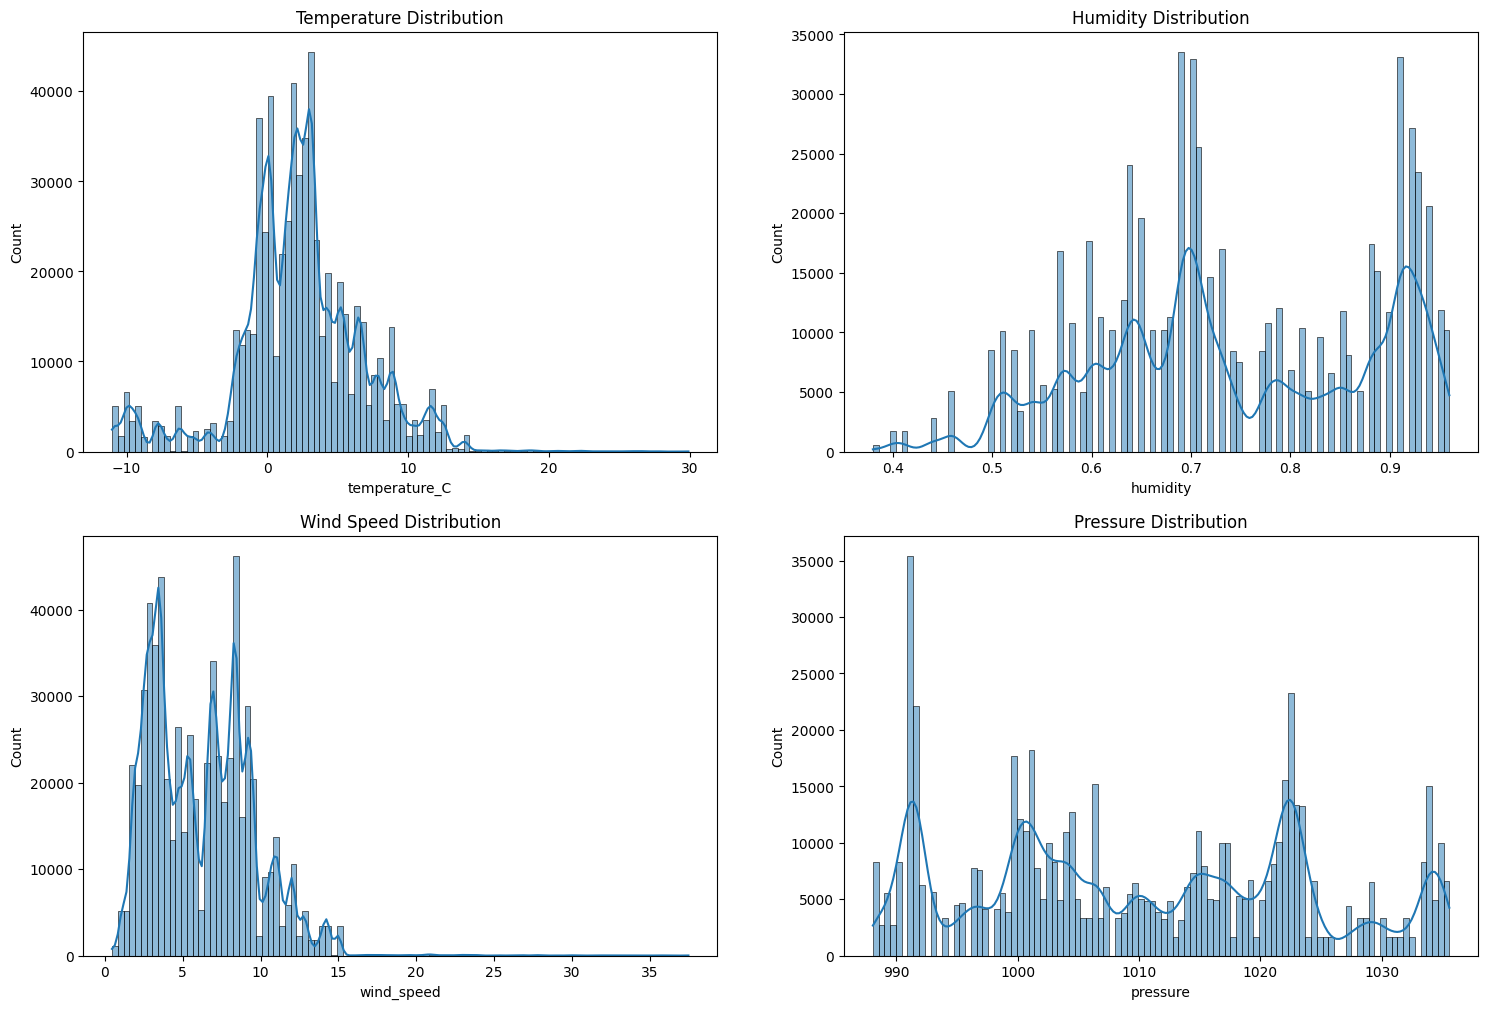

In [56]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.histplot(df["temperature_C"], bins=100, kde=True)
plt.title("Temperature Distribution")

plt.subplot(2,2,2)
sns.histplot(df["humidity"], bins=100, kde=True)
plt.title("Humidity Distribution")

plt.subplot(2,2,3)
sns.histplot(df["wind_speed"], bins=100, kde=True)
plt.title("Wind Speed Distribution")

plt.subplot(2,2,4)
sns.histplot(df["pressure"], bins=100, kde=True)
plt.title("Pressure Distribution")
plt.show()

#### Temperature and Wind Speed column has unrealistic values. So, we replaced the outliers with NaN.

In [57]:
Q3 = df["temperature_C"].quantile(0.75)
Q1 = df["temperature_C"].quantile(0.25)
IQR = Q3 - Q1
temp_threshold = Q3 + 2*IQR
print("Temperature Threshold: ",temp_threshold)
df.loc[df["temperature_C"]>temp_threshold, "temperature_C"] = np.nan

Temperature Threshold:  14.633333333333333


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [58]:
Q3 = df["wind_speed"].quantile(0.75)
Q1 = df["wind_speed"].quantile(0.25)
IQR = Q3 - Q1
wind_threshold = Q3 + 1.5*IQR
print("Wind Speed Threshold: ",wind_threshold)
df.loc[df["wind_speed"]>wind_threshold, "wind_speed"] = np.nan

Wind Speed Threshold:  15.91


In [59]:
df["temperature_C"].isnull().sum()

9559

In [60]:
df["wind_speed"].isnull().sum()

1639

#### The missing values in weather column is filled with forward and backward fill averaging.

In [61]:
weather_cols = ["temperature_C", "humidity", "wind_speed", "pressure"]

for col in weather_cols:
    df[col] = ((df[col].ffill() + df[col].bfill()) / 2).round(2)

#### Weather data distribution after removing outliers and missing values.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

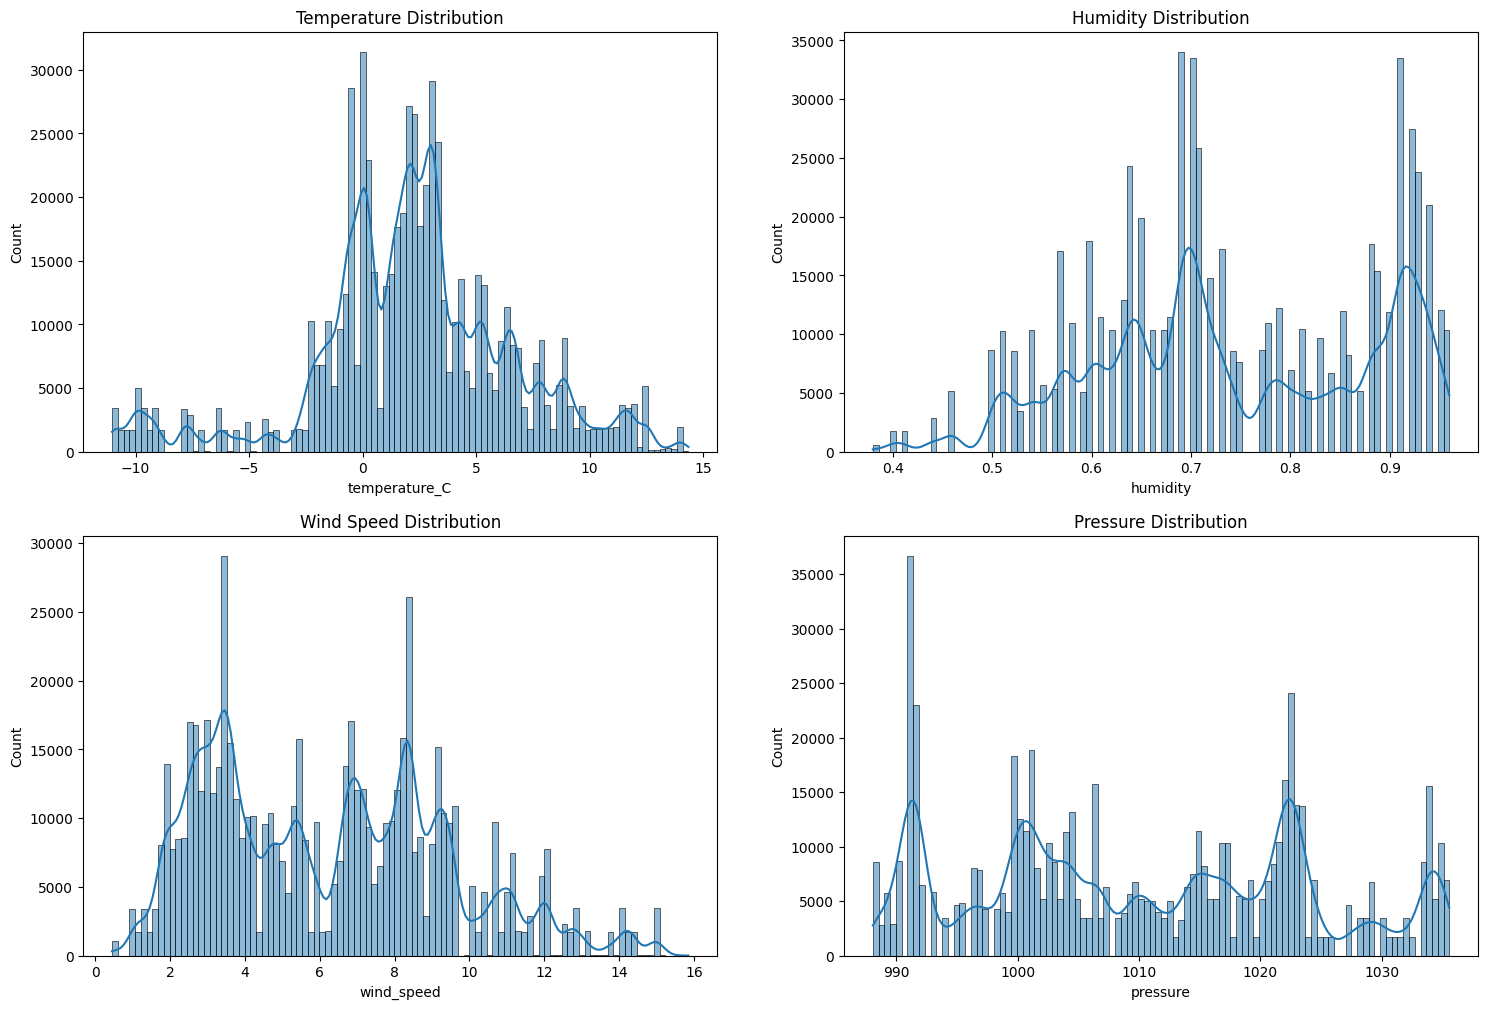

In [62]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.histplot(df["temperature_C"], bins=100, kde=True)
plt.title("Temperature Distribution")

plt.subplot(2,2,2)
sns.histplot(df["humidity"], bins=100, kde=True)
plt.title("Humidity Distribution")

plt.subplot(2,2,3)
sns.histplot(df["wind_speed"], bins=100, kde=True)
plt.title("Wind Speed Distribution")

plt.subplot(2,2,4)
sns.histplot(df["pressure"], bins=100, kde=True)
plt.title("Pressure Distribution")
plt.show()

In [63]:
df.isnull().sum()

timestamp             0
date                  0
hour                  0
day_of_week           0
month                 0
source                0
destination           0
ride_company          0
vehicle               0
visibility            0
cloud_cover           0
uv_index              0
distance              0
surge_multiplier      0
fare                  0
humidity              0
wind_speed            0
weather_desc_short    0
weather_desc_long     0
weather_status        0
pressure              0
temperature_C         0
dtype: int64

In [64]:
df[["uv_index","cloud_cover","visibility"]].describe()

,uv_index,cloud_cover,visibility
count,637194.000000,637194.000000,637194.000000
mean,0.249075,0.686230,8.469312
std,0.474355,0.358629,2.601731
min,0.000000,0.000000,0.717000
25%,0.000000,0.370000,8.432000
50%,0.000000,0.820000,9.880000
75%,0.000000,1.000000,9.996000
max,2.000000,1.000000,10.000000


uv_index, cloud_cover and visibility doesn't have outliers or missing value.

## **Handling weather description data**

In [65]:
df["weather_desc_short"].unique()

array([' Foggy ', ' Foggy !!', ' Overcast ', ' Overcast !!',
       ' Possible Drizzle ', ' Possible Drizzle !!', ' Drizzle ',
       ' Drizzle !!', ' Light Rain ', ' Light Rain !!', ' Rain ',
       ' Rain !!', ' Mostly Cloudy ', ' Mostly Cloudy !!',
       ' Partly Cloudy ', ' Partly Cloudy !!', ' Clear ', ' Clear !!'],
      dtype=object)

In [66]:
df["weather_desc_long"].unique()

array([' Rain in the morning and afternoon. ',
       ' Rain until morning, starting again in the evening. ',
       ' Light rain in the morning. ',
       ' Mostly cloudy throughout the day. ',
       ' Partly cloudy throughout the day. ',
       ' Overcast throughout the day. ',
       ' Light rain in the morning and overnight. ',
       ' Light rain until evening. ', ' Rain throughout the day. ',
       ' Foggy in the morning. ', ' Possible drizzle in the morning. '],
      dtype=object)

The weather_desc_short column contains duplicate values with exclamation marks (e.g., 'Rain' and 'Rain !!'). These indicate the same weather condition and should be treated as a single category.
To clean this, we'll remove the exclamation marks and any leading/trailing whitespace.

In [67]:
# Remove '!!' and any leading/trailing whitespace
df["weather_desc_short"] = df["weather_desc_short"].str.replace("!!", "", regex=False).str.strip()

In [68]:
df["weather_status"].unique()

array([' fog ', '☁️rainn%%', ' cloudy ', ' rain ', ' partly-cloudy-day ',
       ' partly-cloudy-night ', ' clear-night ', ' clear-day '],
      dtype=object)

#### Our preprocessing ends here. Now, we will save the dataset. And, we will read this cleaned dataset from another notebook to do exploratory data analysis.

In [69]:
# df.to_csv("Uber Cleaned Dataset.csv", index=False)